In [4]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

### Hàm co

In [47]:
def erosion(image, kernel):
    rows, cols = image.shape
    
    kernel_size = kernel.shape[0]
    p = kernel_size // 2
    
    
    tmp = np.zeros(((rows + 2 * p), (cols + 2 * p)), dtype=int)
    tmp[p:-p, p:-p] = image.copy()
    
    output = np.zeros_like(image)
    
    for row in range(rows):
        for col in range(cols):
            if tmp[row + p,col + p] != 0:
                s = tmp[row:row + 2 * p + 1, col:col + 2 * p + 1]
                check = ((s & kernel) == kernel).all()
                output[row, col] = int(check)
    return output.astype(np.uint8)

In [6]:
#hàm kiểm tra xem còn tiếp tục co được không
def check_erosion(kernel, img):
    if kernel.shape != img.shape:
        return False

    maskA = np.zeros_like(kernel, dtype=bool)
    maskB = np.zeros_like(img, dtype=bool)

    w, h = maskA.shape

    for i in range(w):
        for j in range(h):
            if kernel[i,j] != 0:
                maskA[i,j] = True
            if img[i,j] != 0:
                maskB[i,j] = True

    maskB = ~maskB
    for i in range(w):
        for j in range(h):
            if maskA[i, j] == maskB[i, j]:
                maskB[i, j] = True

    maskB = ~maskB

    if np.array_equal(maskA, maskB):
        return True

    return False

#hàm co
def erosion_check(image, kernel):
    kernel_size = kernel.shape[0]
    p = kernel.shape[0] // 2
    rows, cols = image.shape
    output = np.zeros((rows, cols))
    tmp = np.zeros((rows + 2 * p, cols + 2 * p))
    tmp[p:-p, p:-p] = image.copy()
    for row in range(rows):
        for col in range(cols):
            s = tmp[row:row + kernel_size, col:col + kernel_size]
            if check_erosion(kernel, s):
                output[row,col] = 1
            else:
                output[row,col] = np.min(s*kernel)
    output = output.astype(np.uint8)
    return output

### Hàm dãn

In [67]:
def dilation(image, kernel):
    rows, cols = image.shape
    
    kernel_size = kernel.shape[0]
    p = kernel_size // 2
    
    tmp = np.zeros(((rows + 2 * p), (cols + 2 * p)), dtype=int)
    tmp[p:-p, p:-p] = image.copy()
    
    output = np.zeros_like(tmp)
    
    for row in range(rows):
        for col in range(cols):
            if tmp[row  + p][col + p] != 0:
                s = tmp[row: row + 2 * p + 1, col: col + 2 * p + 1]
                output[row: row + 2 * p + 1, col: col + 2 * p + 1] = s | kernel
    return output[p:-p, p:-p].astype(np.uint8)

### Hàm Close

In [49]:
def close_image(image, kernel):
    dilated_image = dilation(image, kernel)
    closed_image = erosion(dilated_image, kernel)
    return closed_image

### Hàm Open

In [50]:
def open_image(image, kernel):
    eroded_image = erosion(image, kernel)
    opened_image = dilation(eroded_image, kernel)
    return opened_image

### Hàm tìm ngưỡng tự động

In [72]:
# Tính ngưỡng tự động
def threshold_automatic(image):
    n, m = image.shape
    
    bins, his = np.unique(image, return_counts=True)
    
    t_g = np.cumsum(his) # Tính t(g)
    
    his_times_bins = his * bins # Tính g * h(g)
    
    m_g = (1 / t_g) * np.cumsum(his_times_bins)
    m_G = max(m_g)
    
    f_g = []
    for i in range(len(bins)):
        if n * m - t_g[i] != 0:
            temp = t_g[i] / (m * n - t_g[i]) * (m_g[i] - m_G)**2
            f_g.append(temp)
        else:
            f_g.append(0)
    index = np.where(f_g == max(f_g))
    return bins[index].item()
def segment_with_threshold(image):
    threshold = threshold_automatic(image)
    
    res = np.where(image >= threshold, 1, 0)
    return res

In [118]:
# Nhập vào ảnh
img1 = cv2.imread('data/bienxe.jpg', cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread('data/dongxu2.png', cv2.IMREAD_GRAYSCALE)
img3 = cv2.imread('data/ithinning1.jpg', cv2.IMREAD_GRAYSCALE)
img4 = cv2.imread('data/vantay.jpg', cv2.IMREAD_GRAYSCALE)
img5 = cv2.imread('data/xquang.jpg', cv2.IMREAD_GRAYSCALE)

In [107]:
# Các mặt nạ sử dụng
element = np.ones((3,3), dtype=np.uint8)

kernel1 = np.array([[1, 0, 0],
                    [0, 0, 0],
                    [0, 0, 0]])

kernel2 = np.array([[0, 0, 0],
                    [0, 1, 0],
                    [0, 0, 0]])
kernel3 = np.array([[1, 1, 1],
                    [1, 1 ,1],
                    [1, 1 ,1]])

### Hàm đếm số lượng vật thể bị đè lên nhau

In [54]:
def count_object(gray,n):
    # erosion
    kernel = np.array([[0,1,1,1,0],
                       [1,1,1,1,1],
                       [1,1,1,1,1],
                       [1,1,1,1,1],
                       [0,1,1,1,0]], dtype=int)
    img_erode = erosion(gray, kernel)
    for i in range(n):
        img_erode = erosion(img_erode,kernel)
    #count separate objects 
#     _, labels = cv2.connectedComponents(img_erode)
    labels = np.array([1,2 ,3])
    return len(np.unique(labels)), img_erode

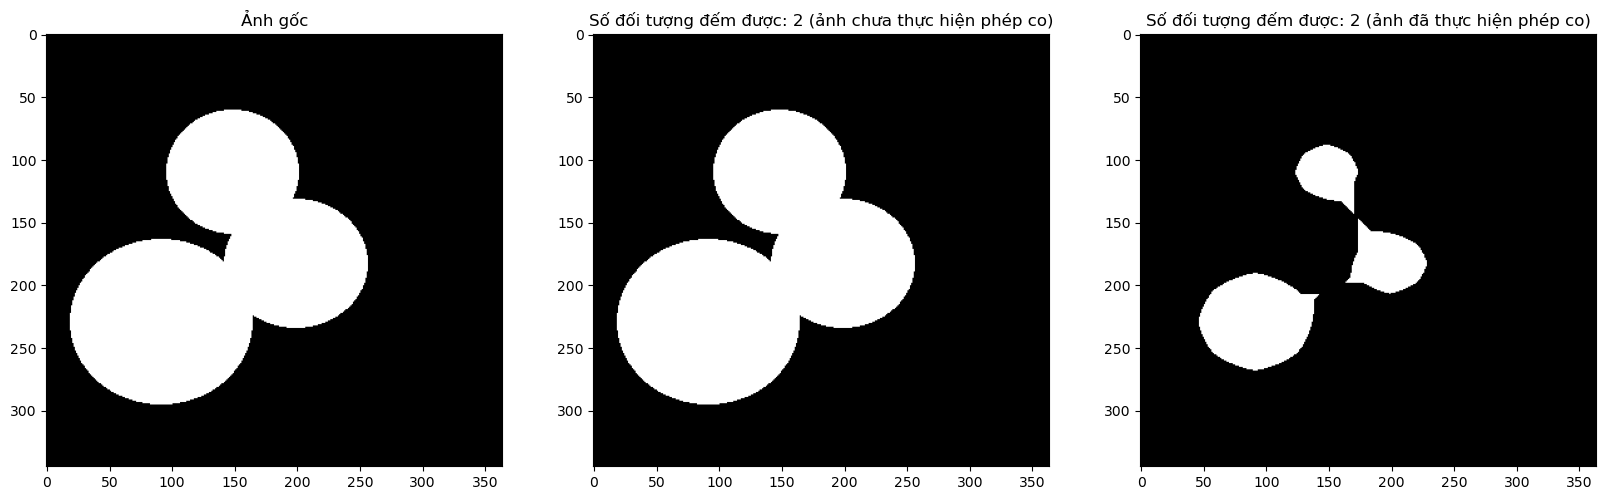

In [56]:
# áp dụng
fig, ax = plt.subplots(1,3, figsize=(20,20))
ax[0].set_title('Ảnh gốc')
ax[0].imshow(img2, cmap='gray')
count1, res1 = count_object(img2, 0)
ax[1].set_title(f'Số đối tượng đếm được: {count1 -1} (ảnh chưa thực hiện phép co)')
ax[1].imshow(img2, cmap='gray')

count2, res2 = count_object(img2, 12)
ax[2].set_title(f'Số đối tượng đếm được: {count2 -1} (ảnh đã thực hiện phép co)')
ax[2].imshow(res2, cmap='gray')
%matplotlib inline

### Hàm làm rõ vân tay

In [119]:
def preprocess_fingerprint(image, kernel):
    eroded = erosion(image, kernel)
    dilated = dilation(eroded, kernel)
    dilated = dilation(dilated, kernel)
    eroded = erosion(dilated, kernel)
    return eroded

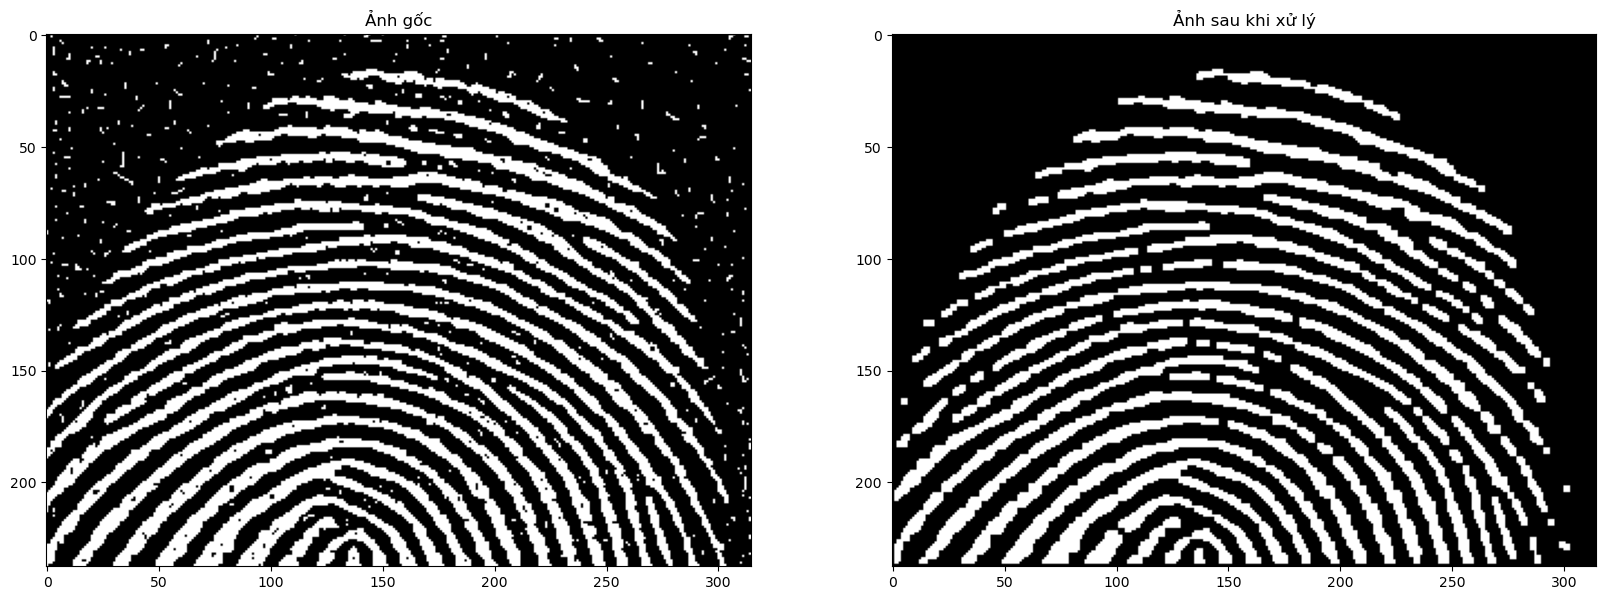

In [120]:
# áp dụng
img4_binary = segment_with_threshold(img4)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 20))
ax1.set_title("Ảnh gốc")
ax1.imshow(img4_binary, cmap='gray')

ax2.set_title("Ảnh sau khi xử lý")
ax2.imshow(preprocess_fingerprint(img4_binary, element), cmap='gray')

### Hàm khôi phục biển số xe

In [165]:
def restore_license_plate(image, kernel): 
    image_binary = segment_with_threshold(image)
    
    eroded = erosion(image_binary, kernel)
    
    opened = open_image(eroded, kernel)
    
#     dilated = dilation(image_binary, kernel)
        
#     eroded = erosion(dilated, kernel)
    
#     for i in range(2):
#         eroded = erosion(eroded, kernel)
#     restored_image = dilation(eroded, kernel)
    return opened

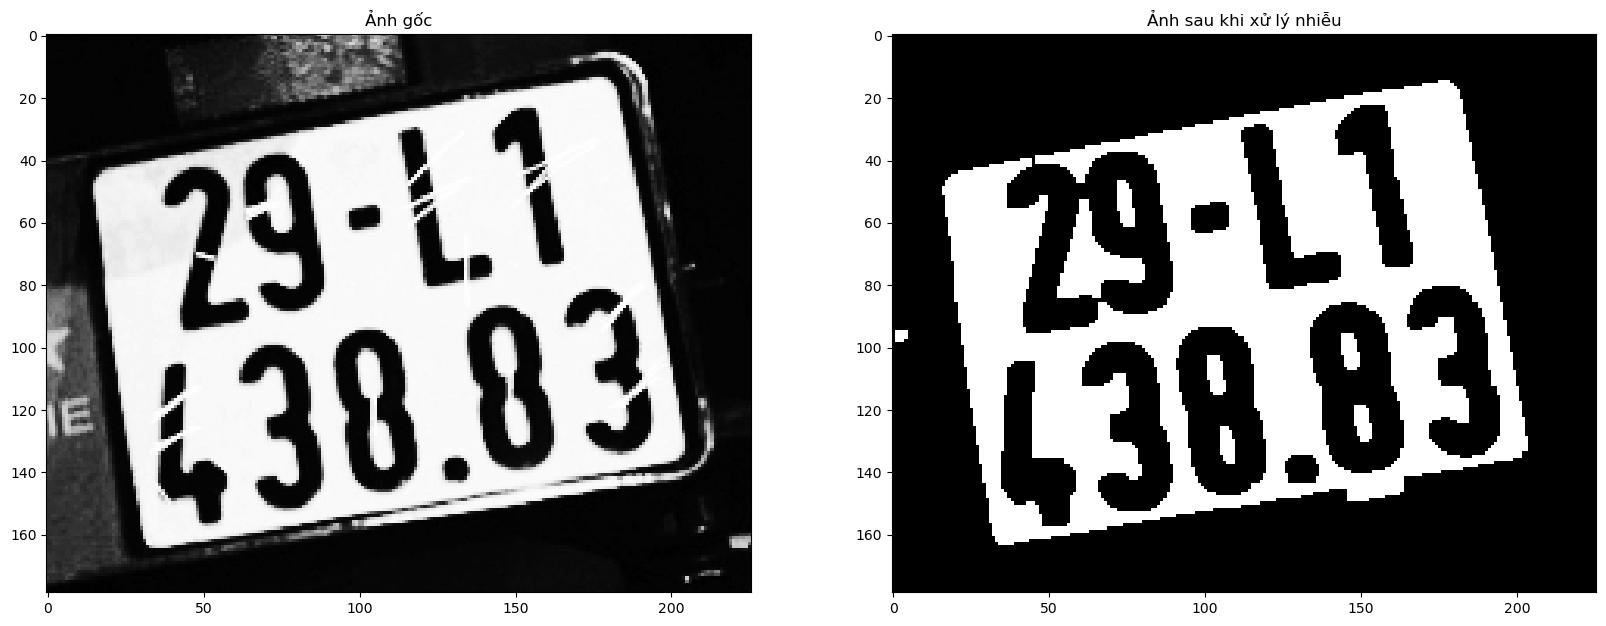

In [167]:
# áp dụng
fig, ax = plt.subplots(1, 2, figsize=(20, 20))
img1_new = restore_license_plate(img1, element)

ax[0].set_title("Ảnh gốc")
ax[0].imshow(img1, cmap='gray')

ax[1].set_title("Ảnh sau khi xử lý nhiễu")
ax[1].imshow(img1_new, cmap='gray')
%matplotlib inline

### Hàm tìm khung xương

In [199]:
def skeleton(img, kernel):
    size = np.size(img)
    
    skel = np.zeros(img.shape, dtype=np.uint8) # Khởi tạo ma trận trả về
    
    img = segment_with_threshold(img) # Phân ngưỡng chuyển về ảnh nhị phân
    img = img.astype(np.uint8) 
    done = False # Khởi tạo vòng lặp


    while (not done):
        eroded = erosion(img, kernel) # Làm mòn biên của vùng sáng
        temp = dilation(eroded, kernel) # Mở rộng vùng sáng
        temp = temp.astype(np.uint8)
        temp = cv2.subtract(img, temp) # Dùng cv2.subtract để đảm bảo không có giá trị âm
        skel = skel | temp # Cập nhật bộ xương
        img = eroded.copy() # Cập nhật ảnh bằng ảnh đã làm mòn biên


        zeros = size - np.count_nonzero(img) # Đếm số điểm đen của ảnh đã cập nhật
        if zeros == size: # Nếu ảnh không còn vùng sáng thì dừng
            done = True
    return skel

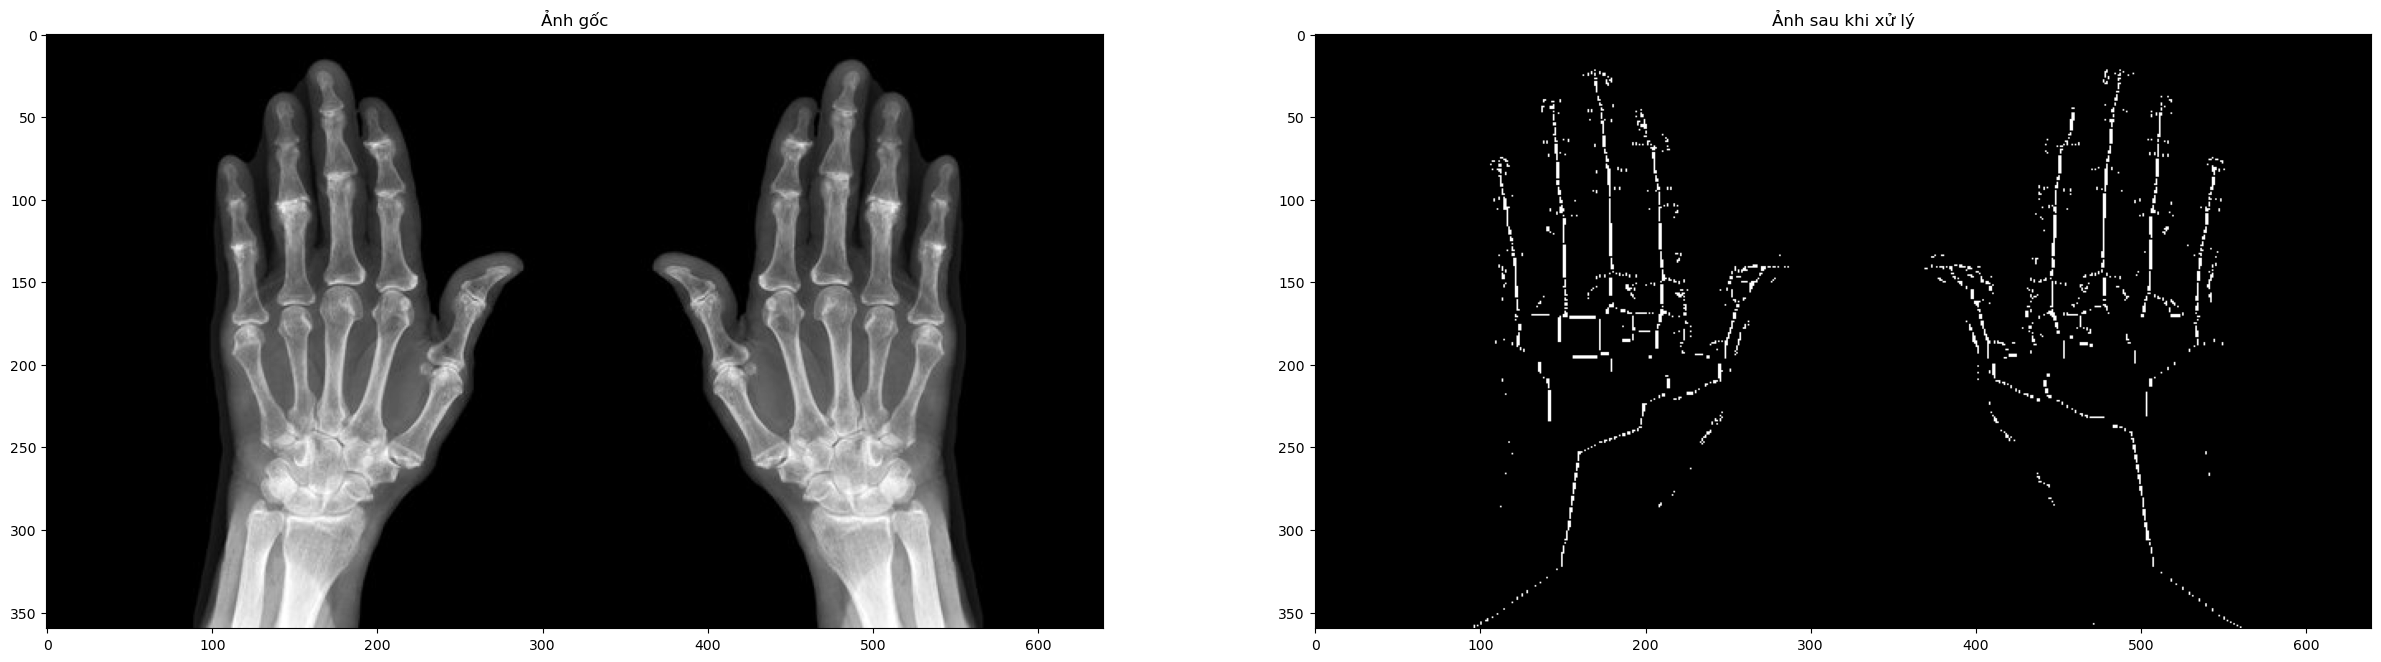

In [200]:
# Áp dụng
fig4, ax4 = plt.subplots(1,2, figsize=(30,30))
ax4[0].set_title('Ảnh gốc')
ax4[0].imshow(img5,cmap='gray')
res5 = skeleton(img5, kernel3)
ax4[1].set_title('Ảnh sau khi xử lý')
ax4[1].imshow(res5, cmap='gray')

In [172]:
# Hàm làm dày
def add(matrix, result):
    for i in range(result.shape[0]):
        for j in range(result.shape[1]):
            if result[i, j] != 0:
                matrix[i, j] = 255
    return matrix
def thickening(matrix, kernel1, kernel2):
    # cv2.imshow("Original Image", matrix)
    matrix_tmp = matrix.copy()
    thick = np.ones(matrix.shape, dtype=np.uint8)
    # Ma trận binary chỉ có 2 giá trị là 0 và 255
    # nên dùng hàm count_nonzero sẽ đếm được số điểm sáng (vật thể)
    while np.count_nonzero(thick) > 500:
        condition = np.count_nonzero(thick)
        # Ma trận bù của ảnh
        matrix_complement = ~matrix_tmp
        # Kết quả của phép co với B1
        result_1 = erosion_check(matrix_tmp, kernel1)
        # Kết quả của phép co với B2
        result_2 = erosion_check(matrix_complement, kernel2)
        # Kết quả của phép hit and miss được tạo nên bằng giao 2 ma trận kết quả trên
        result = cv2.bitwise_and(result_1, result_2)
        thick = result.copy()
        print(np.count_nonzero(thick))
        # Cộng thêm phần muốn làm dày
        count = np.count_nonzero(matrix_tmp)
        matrix_tmp = add(matrix_tmp, result)
        if condition - np.count_nonzero(thick) <= 10:
            break
    return matrix_tmp

2751
1325
1007
890
830
804
791
780
761
740
727
720


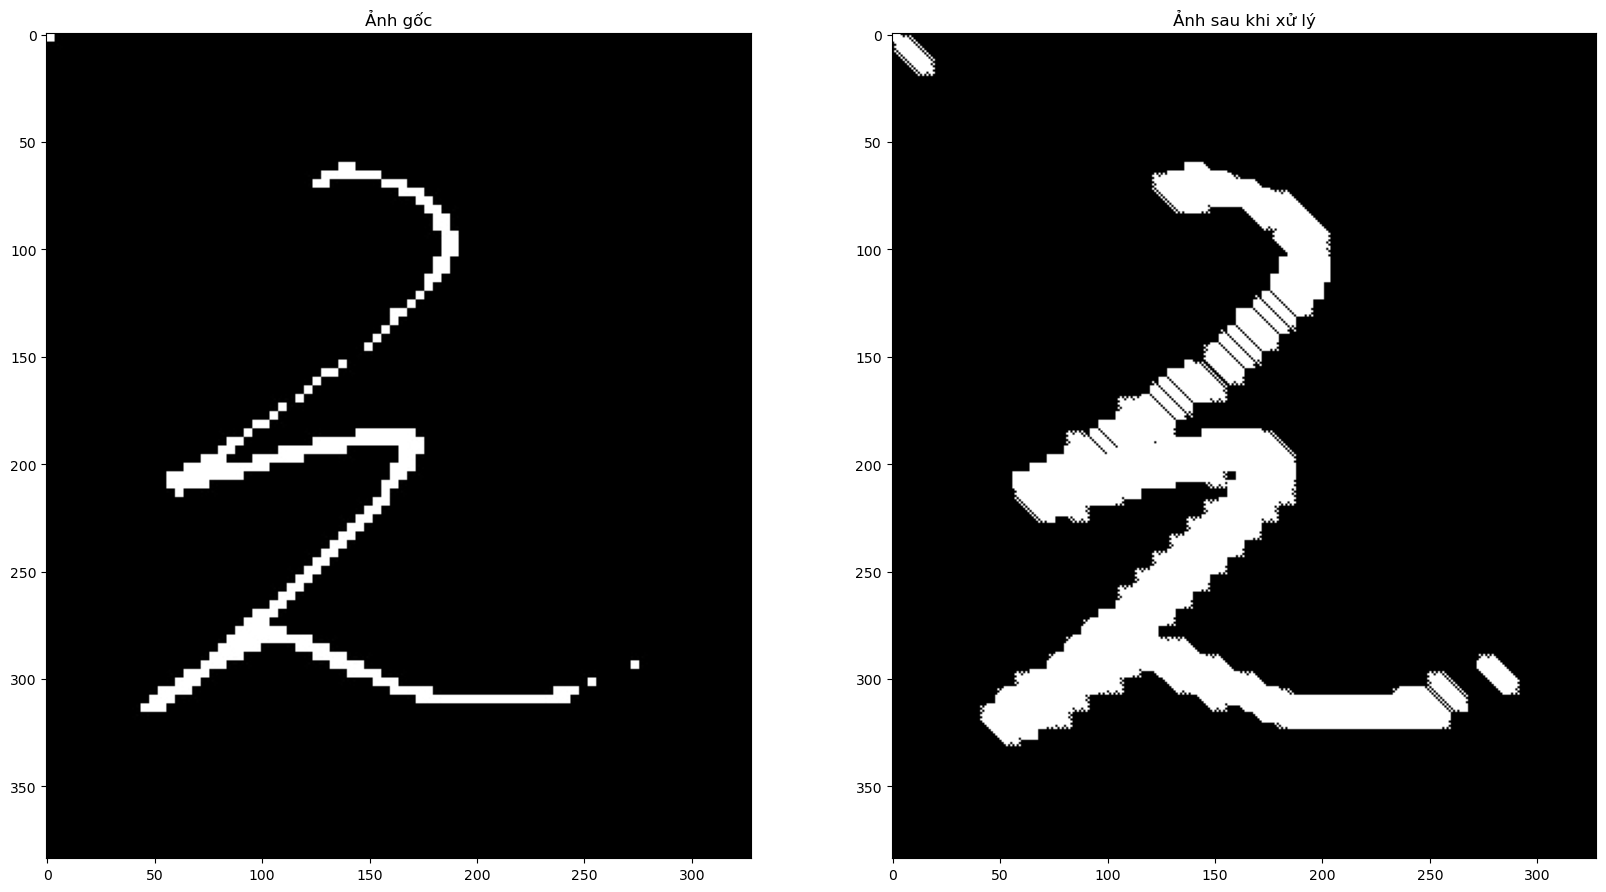

In [88]:
fig, ax = plt.subplots(1, 2, figsize=(20, 20))
ax[0].set_title('Ảnh gốc')
ax[0].imshow(img3, cmap='gray')
res4 = thickening(img3 ,kernel1, kernel2)
ax[1].set_title('Ảnh sau khi xử lý')
ax[1].imshow(res4, cmap='gray')
plt.show()